# **Cheminformatics in Python: Predicting Solubility of Molecules** 


In this Jupyter notebook, we will dive into the world of Cheminformatics which lies at the interface of Informatics and Chemistry. We will be reproducing a research article (by John S. Delaney$^1$) by applying Linear Regression to predict the solubility of molecules (i.e. solubility of drugs is an important physicochemical property in Drug discovery, design and development).

This idea for this notebook was inspired by the excellent blog post by Pat Walters$^2$ where he reproduced the linear regression model with similar degree of performance as that of Delaney. This example is also briefly described in the book ***Deep Learning for the Life Sciences: Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More***.$^3$

## **1. Install rdkit**

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2022-09-09 22:53:53--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.3’

Miniconda3-py37_4.8 100%[===================>]  81.12M  85.7MB/s    in 0.9s    

2022-09-09 22:53:54 (85.7 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.3’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / - \ | / - \ | failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: | / - \ | / - \ | / - 

## **2. Delaney's solubility dataset** 

The original Delaney's dataset available as a Supplementary file 4 . The full paper is entitled ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure. 1

### **2.1. Download the dataset**

In [ ]:
! wget https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv

--2022-09-09 22:54:38--  https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58889 (58K) [text/plain]
Saving to: ‘delaney.csv.3’

delaney.csv.3       100%[===================>]  57.51K  --.-KB/s    in 0.006s  

2022-09-09 22:54:38 (9.40 MB/s) - ‘delaney.csv.3’ saved [58889/58889]



### **2.2. Read in the dataset**

In [ ]:
import pandas as pd

In [ ]:
sol = pd.read_csv("delaney.csv")
sol

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


### **2.3. Examine the SMILES data**


Chemical structures are encoded by a string of text known as **SMILES** which is an acronym for **Simplified Molecular-Input Line-Entry System**.

In [ ]:
sol.SMILES

0                                    ClCC(Cl)(Cl)Cl
1                                      CC(Cl)(Cl)Cl
2                                    ClC(Cl)C(Cl)Cl
3                                        ClCC(Cl)Cl
4                               FC(F)(Cl)C(F)(Cl)Cl
                           ...                     
1139                   CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140          CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141         CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O 
1142    Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O
1143                         CNC(=O)Oc1cc(C)cc(C)c1
Name: SMILES, Length: 1144, dtype: object

The first element from the **SMILES** column of the **sol** dataframe.

In [ ]:
sol.SMILES[0]

'ClCC(Cl)(Cl)Cl'

### **2.4. Convert a molecule from the SMILES string to an rdkit object**

In [ ]:
from rdkit import Chem

In [ ]:
Chem.MolFromSmiles(sol.SMILES[0])

In [ ]:
Chem.MolFromSmiles('ClCC(Cl)(Cl)Cl')

In [ ]:
m = Chem.MolFromSmiles('ClCC(Cl)(Cl)Cl')

In [ ]:
m.GetNumAtoms()

6

## **3. Calculate molecular descriptors in rdkit** 

### **3.1. Convert list of molecules to rdkit object**

In [ ]:
from rdkit import Chem

In [ ]:
mol_list = [Chem.MolFromSmiles(element) for element in sol.SMILES]

In [ ]:
len(mol_list)

1144

In [ ]:
mol_list[:5]

### **3.2. Calculate molecular descriptors**

To predict **LogS** (log of the aqueous solubility), the study by Delaney makes use of 4 molecular descriptors:
1. **cLogP** *(Octanol-water partition coefficient)*
2. **MW** *(Molecular weight)*
3. **RB** *(Number of rotatable bonds)*
4. **AP** *(Aromatic proportion = number of aromatic atoms / total number of heavy atoms)*

Unfortunately, rdkit readily computes the first 3. As for the AP descriptor, we will calculate this by manually computing the ratio of the *number of aromatic atoms* to the *total number of heavy atoms* which rdkit can compute.

#### **3.2.1. LogP, MW and RB**

In [ ]:
import numpy as np
from rdkit.Chem import Descriptors

In [ ]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def generate(smiles, verbose=False):

  moldata = []
  for elem in smiles:
    mol = Chem.MolFromSmiles(elem)
    moldata.append(mol)

  baseData = np.arange(1,1)
  i = 0
  for mol in moldata:

    desc_MolLogP = Descriptors.MolLogP(mol)
    desc_MolWt = Descriptors.MolWt(mol)
    desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)

    row = np.array([desc_MolLogP,
                    desc_MolWt,
                    desc_NumRotatableBonds])
    
    if (i == 0):
      baseData = row
    else: 
      baseData = np.vstack([baseData, row])
    
    i = i + 1

  columnNames = ["MolLogP", "MolWt", "NumRotatableBonds"]
  descriptors = pd.DataFrame(data=baseData, columns=columnNames)

  return descriptors

In [ ]:
df = generate(sol.SMILES)
df

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


#### **3.2.2. Aromatic proportion**

Here, we will create a custom function to calculate the Number of aromatic atoms. With this descriptor we can use it to subsequently calculate the AP descriptor.

Computing for a single molecule:

In [ ]:
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')

In [ ]:
aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range (m.GetNumAtoms())]
aromatic_atoms

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True]

In [ ]:
def AromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if (i == True):
      aa_count.append(1)
  sum_aa_count = sum(aa_count)
  return sum_aa_count

In [ ]:
AromaticAtoms(m)

19

Computing for molecules in the entire dataset:

In [ ]:
desc_AromaticAtoms = [AromaticAtoms(element) for element in mol_list]
desc_AromaticAtoms

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 6,
 0,
 0,
 6,
 10,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 10,
 6,
 0,
 10,
 0,
 14,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 12,
 10,
 14,
 6,
 10,
 10,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 0,
 12,
 12,
 12,
 12,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 6,
 6,
 12,
 12,
 6,
 0,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 10,
 0,
 6,
 12,
 12,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 12,
 12,
 6,
 10,
 6,
 6,
 6,
 12,
 10,
 14,
 10,
 10,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 12,
 0,
 10,
 6,
 0,
 6,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 6,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,

**Number of heavy atoms**

Computing for a single molecule:

In [ ]:
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
Descriptors.HeavyAtomCount(m)

34

Computing for molecules in the entire dataset:

In [ ]:
desc_HeavyAtomCount = [Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_HeavyAtomCount

[6,
 5,
 6,
 5,
 8,
 4,
 4,
 8,
 10,
 10,
 10,
 9,
 9,
 10,
 10,
 10,
 9,
 9,
 9,
 8,
 8,
 4,
 8,
 4,
 5,
 8,
 8,
 10,
 12,
 4,
 9,
 9,
 9,
 15,
 8,
 4,
 8,
 8,
 5,
 8,
 8,
 12,
 12,
 8,
 6,
 8,
 8,
 10,
 8,
 12,
 12,
 5,
 12,
 6,
 14,
 11,
 22,
 15,
 5,
 5,
 8,
 7,
 11,
 9,
 6,
 4,
 5,
 4,
 4,
 4,
 5,
 5,
 8,
 7,
 11,
 6,
 4,
 11,
 10,
 13,
 12,
 8,
 7,
 7,
 17,
 7,
 6,
 7,
 6,
 5,
 8,
 11,
 4,
 7,
 14,
 11,
 15,
 9,
 11,
 11,
 13,
 6,
 10,
 9,
 9,
 19,
 9,
 8,
 8,
 16,
 6,
 5,
 5,
 9,
 4,
 15,
 22,
 20,
 18,
 20,
 18,
 16,
 19,
 19,
 18,
 17,
 17,
 18,
 16,
 7,
 18,
 18,
 16,
 17,
 8,
 9,
 16,
 7,
 6,
 7,
 8,
 6,
 14,
 18,
 19,
 18,
 17,
 17,
 16,
 11,
 11,
 15,
 15,
 10,
 8,
 11,
 15,
 10,
 10,
 11,
 9,
 6,
 6,
 12,
 7,
 8,
 15,
 15,
 10,
 15,
 10,
 10,
 16,
 9,
 8,
 8,
 8,
 7,
 9,
 8,
 13,
 14,
 14,
 9,
 12,
 9,
 8,
 13,
 14,
 12,
 15,
 11,
 11,
 4,
 8,
 5,
 5,
 8,
 6,
 9,
 13,
 5,
 11,
 8,
 4,
 8,
 6,
 11,
 8,
 7,
 9,
 9,
 7,
 9,
 12,
 9,
 8,
 8,
 7,
 7,
 11,
 7,
 4,
 10,
 12,
 5,

**Commputing the Aromatic Proportion (AP) descriptor**

Computing for a single molecule:

In [ ]:
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
AromaticAtoms(m)/Descriptors.HeavyAtomCount(m)

0.5588235294117647

Computing for molecules in the entire dataset:

In [ ]:
desc_AromaticProportion = [AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_AromaticProportion

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6,
 0.6,
 0.6,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.75,
 0.75,
 0.0,
 0.75,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6,
 0.5,
 0.0,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.4,
 0.75,
 0.0,
 0.75,
 0.75,
 0.0,
 0.0,
 0.75,
 0.8333333333333334,
 0.5,
 0.75,
 0.0,
 0.75,
 0.75,
 0.6,
 0.75,
 0.8333333333333334,
 0.5,
 0.0,
 0.8333333333333334,
 0.0,
 1.0,
 0.0,
 0.0,
 0.9333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8333333333333334,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9090909090909091,
 0.0,
 0.0,
 0.8571428571428571,
 0.9090909090909091,
 0.9333333333333333,
 0.6666666666666666,
 0.9090909090909091,
 0.9090909090909091,
 0.7692307692307693,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0

In [ ]:
df_desc_AromaticProportion = pd.DataFrame(desc_AromaticProportion, columns=['AromaticProportion'])
df_desc_AromaticProportion

,AromaticProportion
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


### **3.3. X Matrix (Combining all computed descriptors into one dataframe)**

In [ ]:
df

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


In [ ]:
df_desc_AromaticProportion

,AromaticProportion
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


In [ ]:
X = pd.concat([df, df_desc_AromaticProportion], axis=1)
X

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
0,2.59540,167.850,0.0,0.000000
1,2.37650,133.405,0.0,0.000000
2,2.59380,167.850,1.0,0.000000
3,2.02890,133.405,1.0,0.000000
4,2.91890,187.375,1.0,0.000000
...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000
1140,3.42130,286.114,2.0,0.333333
1141,3.60960,308.333,4.0,0.695652
1142,2.56214,354.815,3.0,0.521739


### **3.4. Y Matrix**

In [ ]:
sol.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


Assigning the second column (index 1) to the Y Matrix

In [ ]:
Y = sol.iloc[:,1]
Y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: measured log(solubility:mol/L), Length: 1144, dtype: float64

## **Data split**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## **Linear Regression Model**

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

## **Predict the X_train**

In [ ]:
Y_pred_train = model.predict(X_train)

In [ ]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Coefficients: [-0.78070582 -0.00651972  0.00622703 -0.32226306]
Intercept: 0.2903928926570778
Mean squared error (MSE): 0.97
Coefficient of determination (R^2): 0.77


## **Predict the Y_train**

In [ ]:
Y_pred_test = model.predict(X_test)

In [ ]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Coefficients: [-0.78070582 -0.00651972  0.00622703 -0.32226306]
Intercept: 0.2903928926570778
Mean squared error (MSE): 1.18
Coefficient of determination (R^2): 0.75


### **Linear Regression Equation**

The work of Delaney$^1$ provided the following linear regression equation:

> LogS = 0.16 -  0.63 cLogP - 0.0062 MW + 0.066 RB - 0.74 AP

The reproduction by Pat Walters$^2$ provided the following:

> LogS = 0.26 -  0.74 LogP - 0.0066 MW + 0.0034 RB - 0.42 AP

This notebook's reproduction gave the following equation:

* Based on the Train set
> LogS = 0.30 -0.75 LogP - .0066 MW -0.0041 RB - 0.36 AP

* Based on the Full dataset
> LogS =  0.26 -0.74 LogP - 0.0066 + MW 0.0032 RB - 0.42 AP

In [ ]:
print('LogS = %.2f %.2f LogP %.4f MW %.4f RB %.2f AP' % (model.intercept_, model.coef_[0], model.coef_[1], model.coef_[2], model.coef_[3] ) )

LogS = 0.29 -0.78 LogP -0.0065 MW 0.0062 RB -0.32 AP


Demonstration of derivation of linear regression equation:

In [ ]:
yintercept = '%.2f' % model.intercept_
LogP = '%.2f LogP' % model.coef_[0]
MW = '%.4f MW' % model.coef_[1]
RB = '%.4f RB' % model.coef_[2]
AP = '%.2f AP' % model.coef_[3]

In [ ]:
print('LogS = ' + 
      ' ' + 
      yintercept + 
      ' ' + 
      LogP + 
      ' ' + 
      MW + 
      ' ' + 
      RB + 
      ' ' + 
      AP)

LogS =  0.29 -0.78 LogP -0.0065 MW 0.0062 RB -0.32 AP


#### **Use entire dataset for model training (For Comparison)**

In [ ]:
full = linear_model.LinearRegression()
full.fit(X, Y)

LinearRegression()

In [ ]:
full_pred = model.predict(X)

In [ ]:
print('Coefficients:', full.coef_)
print('Intercept:', full.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y, full_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y, full_pred))

Coefficients: [-0.74173609 -0.00659927  0.00320051 -0.42316387]
Intercept: 0.2565006830997185
Mean squared error (MSE): 1.01
Coefficient of determination (R^2): 0.77


In [ ]:
full_yintercept = '%.2f' % full.intercept_
full_LogP = '%.2f LogP' % full.coef_[0]
full_MW = '%.4f MW' % full.coef_[1]
full_RB = '+ %.4f RB' % full.coef_[2]
full_AP = '%.2f AP' % full.coef_[3]

In [ ]:
print('LogS = ' + 
      ' ' + 
      full_yintercept + 
      ' ' + 
      full_LogP + 
      ' ' + 
      full_MW + 
      ' ' + 
      full_RB + 
      ' ' + 
      full_AP)

LogS =  0.26 -0.74 LogP -0.0066 MW + 0.0032 RB -0.42 AP


## **Scatter plot of experimental vs. predicted LogS**

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
Y_train.shape, Y_pred_train.shape

((915,), (915,))

In [ ]:
Y_test.shape, Y_pred_test.shape

((229,), (229,))

## **Vertical plot**

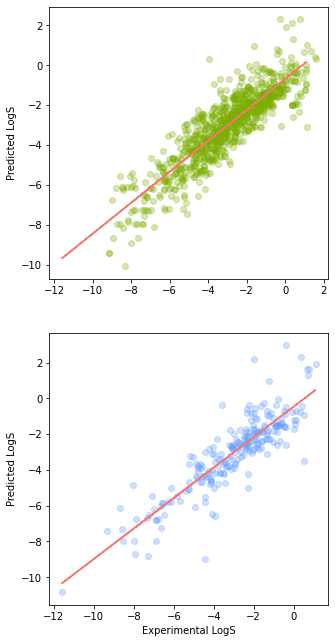

In [ ]:
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.3)

# Add trendline
# https://stackoverflow.com/questions/26447191/how-to-add-trendline-in-python-matplotlib-dot-scatter-graphs
z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

plt.savefig('plot_vertical_logS.png')
plt.savefig('plot_vertical_logS.pdf')
plt.show()

## **Horizontal plot**

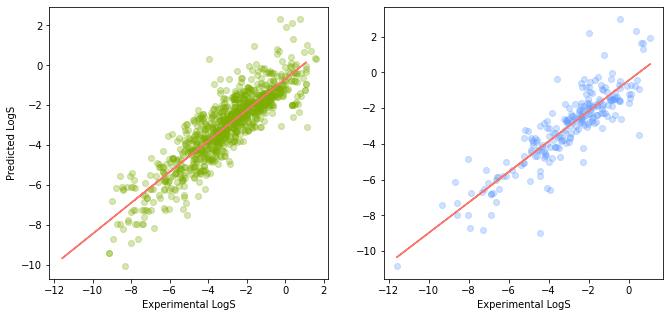

In [ ]:
plt.figure(figsize=(11,5))

# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.3)

z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

# 1 row, 2 column, plot 2
plt.subplot(1, 2, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.xlabel('Experimental LogS')

plt.savefig('plot_horizontal_logS.png')
plt.savefig('plot_horizontal_logS.pdf')
plt.show()

In [ ]:
! ls -l

total 332668
-rw-r--r-- 1 root root    58889 Sep  9 19:05 delaney.csv
-rw-r--r-- 1 root root    58889 Sep  9 21:20 delaney.csv.1
-rw-r--r-- 1 root root    58889 Sep  9 22:29 delaney.csv.2
-rw-r--r-- 1 root root    58889 Sep  9 22:54 delaney.csv.3
-rwxr-xr-x 1 root root 85055499 Mar 11  2020 Miniconda3-py37_4.8.2-Linux-x86_64.sh
-rw-r--r-- 1 root root 85055499 Mar 11  2020 Miniconda3-py37_4.8.2-Linux-x86_64.sh.1
-rw-r--r-- 1 root root 85055499 Mar 11  2020 Miniconda3-py37_4.8.2-Linux-x86_64.sh.2
-rw-r--r-- 1 root root 85055499 Mar 11  2020 Miniconda3-py37_4.8.2-Linux-x86_64.sh.3
-rw-r--r-- 1 root root    29978 Sep  9 22:54 plot_horizontal_logS.pdf
-rw-r--r-- 1 root root    50564 Sep  9 22:54 plot_horizontal_logS.png
-rw-r--r-- 1 root root    29983 Sep  9 22:54 plot_vertical_logS.pdf
-rw-r--r-- 1 root root    53081 Sep  9 22:54 plot_vertical_logS.png
drwxr-xr-x 1 root root     4096 Aug 31 13:47 sample_data


## **Install PyCaret**

In [ ]:
! pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Read in dataset**

In [ ]:
import pandas as pd

In [ ]:
delaney_with_descriptors_url = 'https://raw.githubusercontent.com/dataprofessor/data/master/delaney_solubility_with_descriptors.csv'
dataset = pd.read_csv(delaney_with_descriptors_url)

In [ ]:
dataset

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,logS
0,2.59540,167.850,0.0,0.000000,-2.180
1,2.37650,133.405,0.0,0.000000,-2.000
2,2.59380,167.850,1.0,0.000000,-1.740
3,2.02890,133.405,1.0,0.000000,-1.480
4,2.91890,187.375,1.0,0.000000,-3.040
...,...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000,1.144
1140,3.42130,286.114,2.0,0.333333,-4.925
1141,3.60960,308.333,4.0,0.695652,-3.893
1142,2.56214,354.815,3.0,0.521739,-3.790


## **Model Building**

In [ ]:
from pycaret.regression import *

In [ ]:
! conda install -c free scikit-learn 

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    joblib-1.1.0               |     pyhd3eb1b0_0         211 KB
    libgfortran-ng-7.5.0       |      ha8ba4b0_17          22 KB
    libgfortran4-7.5.0         |      ha8ba4b0_17         995 KB
    scikit-learn-1.0.2         |   py37h51133e4_1         5.5 MB
    scipy-1.7.3                |   py37hc147768_0        16.4 MB
    threadpoolctl-2.2.0        |     pyh0d69192_0          16 KB
    ------------------------------------------------------------
                                           Total:        23.0 MB

The following NEW packages will be INSTALLED:

  joblib             pkgs/main/noarch::joblib-1

In [ ]:
model = setup(data = dataset, target = 'logS', train_size=0.8, silent=True)

INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: regression
INFO:logs:version 2.3.10
INFO:logs:Initializing setup()
INFO:logs:setup(target=logS, ml_usecase=regression, available_plots={'parameter': 'Hyperparameters', 'residuals': 'Residuals', 'error': 'Prediction Error', 'cooks': 'Cooks Distance', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'vc': 'Validation Curve', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'tree': 'Decision Tree', 'residuals_interactive': 'Interactive Residuals'}, train_size=0.8, test_data=None, preprocess=True, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=constant, categorical_iterative_imputer=lightgbm, ordinal_features=None, high_cardinality_features=None, high_cardinality_method=frequency, numeric_features=None, numeric_imputation=mean, numeric_iterative_imputer=lightgbm, date_features=None, ignore_features=None, norm

RuntimeError: ignored